In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
experiment = "kaggle_hashcode"

In [3]:
filepath = os.path.join("input_data", experiment+".txt")
f = open(filepath)

In [4]:
first_line = f.readline()
vals = first_line.split(" ")
D = int(vals[0])
I = int(vals[1])
S = int(vals[2])
V = int(vals[3])
F = int(vals[4])
print("D={}, I={}, S={}, V={}, F={}".format(D,I,S,V,F))

D=7071, I=8000, S=63968, V=1000, F=1000


In [5]:
# Create mapping streetname to id {"streetname": id}
mapping_streetnames = {}
inverse_mapping = []
outgoing_streets = {}
incoming_streets = {}
street_connectors = {}
street_durations = {}

i = 0;
while i < S:
    l = f.readline()
    vals = l.split(" ")
    B = int(vals[0])     # intersection beginning of the street
    E = int(vals[1])     # intersection end of the street
    name = vals[2]       # street name
    L = int(vals [3]) 
    mapping_streetnames[name] = i
    inverse_mapping.append(name)
    
    try:
        streets = outgoing_streets[B]
        streets.append(name)
        outgoing_streets[B] = streets
    except:
        # key Error
        outgoing_streets[B] = [name]
    
    try:
        streets = incoming_streets[E]
        streets.append(name)
        incoming_streets[E] = streets
    except:
        # key Error
        incoming_streets[E] = [name]
    
    street_connectors[name] = {"B": B, "E": E}
    street_durations[name] = L
    i += 1
 
#print(outgoing_streets)
#print(incoming_streets)



In [7]:
#print(mapping_streetnames)
#print(inverse_mapping)

In [8]:
# Create ranking how many times a street is part of a path.
ranking = np.zeros(S)

for j in range(V):
    l = f.readline()
    vals = l.split("\n")[0].split(" ")
    for i in range(1,int(vals[0])): # do not consider last street because last intersection isn't travelled through
        street_on_path = vals[i]
        ranking[mapping_streetnames[street_on_path]] += 1
        
    

In [9]:
print(max(ranking))

10.0


In [10]:
threshold = np.median(ranking)
print("min:{}".format(np.min(ranking)))
print("max:{}".format(np.max(ranking)))
print("threshold: {}".format(threshold))

min:0.0
max:10.0
threshold: 2.0


In [11]:
common_streets = []
for i in range(len(ranking)):
    if ranking[i] > threshold:
        common_streets.append(inverse_mapping[i])
#print(common_streets)
        
    

In [12]:
def give_following_street(streetname):
    
    intersection_end = street_connectors[streetname]["E"]
    
    return outgoing_streets[intersection_end] #what happens if there is no street after the street?
    
def give_previous_street(streetname):
    
    intersection_begining = street_connectors[streetname]["B"]
    
    return incoming_streets[intersection_begining]

In [13]:
def recursive_next_street(current_street):
    following_streets = give_following_street(current_street)
    for fs in following_streets:
        if fs in common_streets:
            # todo: take the street with the highest ranking instead of the first one
            common_forward_path.append(fs)
            common_streets.remove(fs)
            recursive_next_street(fs)
            break
    return 

In [14]:
def recursive_previous_street(current_street):
    previous_streets = give_previous_street(current_street)
    for ps in previous_streets:
        if ps in common_streets:
            # todo
            common_backwards_path.append(ps)
            common_streets.remove(ps)
            recursive_previous_street(ps)
            break
    return

In [15]:
common_paths = [] #[["a","b","c"], ["d","e"]]

while len(common_streets) > 0:
    
    # forward
    street = common_streets[0]
    common_forward_path = [street]
    common_streets.remove(street)
    recursive_next_street(street)
    
    # backward
    common_backwards_path = []
    recursive_previous_street(street)

    # merge them
    if(len(common_forward_path) == 1 and len(common_backwards_path) == 0):
        continue
    
    new_path = []
    for subpath in reversed(common_backwards_path):
        new_path.append(subpath)
    
    
    new_path += common_forward_path
    
    common_paths.append(new_path)

  

In [19]:
print(len(common_paths))

1968


[474, 267, 219, 187, 108, 102, 98, 94, 94, 88, 88, 88, 88, 86, 81, 81, 77, 77, 77, 77, 74, 73, 71, 67, 65, 63, 63, 61, 61, 60, 60, 59, 58, 57, 57, 57, 56, 55, 55, 53, 52, 52, 52, 50, 48, 48, 47, 47, 47, 47, 46, 46, 45, 45, 45, 44, 44, 44, 44, 43, 42, 42, 42, 42, 42, 41, 40, 40, 39, 39, 39, 39, 37, 36, 36, 35, 35, 35, 35, 35, 35, 34, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 30, 30, 30]


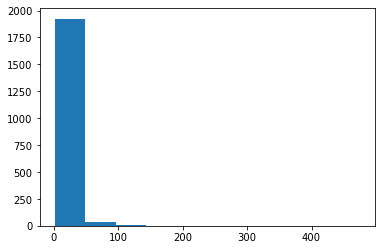

In [26]:
lengths = []
for p in common_paths: 
    lengths.append(len(p))

plt.figure()
plt.hist(lengths)
print(sorted(lengths, reverse=True)[:100])

# Reasoning:
# for kaggle dataset: length of the path always 120 -> common path with len 474 longer than path of any vehicle
# that show why the optimization does not work
# the common paths are much longer than any section of streets part of a vehicles route
# the common paths are just connections of streets that were used by multiple cars (most of the time
# just a few times compared to the simulation duration )


In [ ]:
def sort_longest_paths(paths):
    sorted_path = sorted(paths, key=len, reverse=True)
    return sorted_path

sorted_common_paths = sort_longest_paths(common_paths)
print(len(sorted_common_paths[0]))
print(len(sorted_common_paths[-1]))

In [ ]:

#schedule = [
#  [{"is_1":0}, {"is_2":0}], #Intersection 0  TUUUPLES!!
#  [{"is_1":0}, {"is_2":0}], #Intersection 1
#]

schedule = []
statistics_num_inc_streets = []
for intersection_id in range(I):
    is_schedule = []
    
    #todo: limit to the incoming streets where there is traffic
    ##print(incoming_streets[intersection_id])
    ##print(len(incoming_streets[intersection_id]))
    for p in incoming_streets[intersection_id]:
        is_schedule.append([ p, 0 ] )
    statistics_num_inc_streets.append(len(incoming_streets[intersection_id]))
    schedule.append(is_schedule)  
    

In [ ]:
#print(statistics_num_inc_streets)

In [ ]:
count_can_optimize = 0
count_need_extra_delay = 0

for current_path in sorted_common_paths:
    
    #at T = 0, the car is at the end of the begining of the first street of the common path
    #current_path = sorted_common_paths[0]

    T = 0
    t_accumulated = 0

    debug_list_mod_int = []

    for street in current_path:
        t_accumulated += street_durations[street]

        next_intersection_id = street_connectors[street]["E"]
        debug_list_mod_int.append(next_intersection_id)

        int_schedule = schedule[next_intersection_id]

        #calculate desired position
        desired_position = t_accumulated % len(int_schedule) # assuming schedule will only have one's

        # try optimize schedule 
        considered_inc_street = street


        current_position = None
        for index_d, val in enumerate(int_schedule):
            if val[0]==considered_inc_street:
                current_position = index_d
                break

        optimization_possible = (int_schedule[desired_position][1] == 0)

        extra_delay = 0

        if optimization_possible:
            ##print("We can optimize")
            ##print("original schedule: ", int_schedule)
            # swap the tuple corresponding to the desired incoming street with the non optimal tuple with Ti=0

            count_can_optimize += 1
            
            tmp_desired = [considered_inc_street, 1]    
            tmp_swaped = int_schedule[desired_position]
            int_schedule[current_position] = tmp_swaped
            int_schedule[desired_position] = tmp_desired

            #[{"is_1":0}, {"is_2":0}, {"is_3":0},{"is_3":0}]
        else:
            ##print("We cannot optimize")
            # calculate extra delay
            count_need_extra_delay += 1 
            extra_delay = abs(current_position - desired_position)
            #print("extra_delay: ", extra_delay)

        t_accumulated += extra_delay

print("#can optimize: ", count_can_optimize)
print("#need extra delay: ", count_need_extra_delay)

In [ ]:
for s in schedule:
    for e in s:
        if e[-1] != 0:
            print(s, "\n")

In [ ]:
for line in debug_list_mod_int:
    print(schedule[line])

In [ ]:
filename =  "generated_schedule/schedule_" + experiment + ".txt"

with open(filename, 'w') as f:
    f.write("{} \n".format(str(I))) # number of intersections with traffic light schedules

    for int_id, s in enumerate(schedule):
        lines = []
        for entry in s:
            #check if street has value > 0 in ranking
            if ranking[mapping_streetnames[entry[0]]] > 0:
                lines.append("{} {} \n".format(entry[0], 1))      # streetname Ti
        if len(lines)>0:        
            f.write("{} \n".format(str(int_id)))   # id
            f.write("{} \n".format((str(len(lines)))))  # number of incoming streets with schedule
            for l in lines:
                f.write(l)      

In [ ]:
filename =  "generated_schedule/schedule_" + experiment + ".txt"

lines = []
intersection_counter = 0
for int_id, s in enumerate(schedule):    
    tmp = []
    for entry in s:
        #check if street has value > 0 in ranking
        if ranking[mapping_streetnames[entry[0]]] > 0:
            tmp.append("{} {} \n".format(entry[0], 1))      # streetname Ti
    if len(tmp)>0:
        intersection_counter += 1
        lines.append("{} \n".format(str(int_id)))   # id
        lines.append("{} \n".format((str(len(tmp)))))  # number of incoming streets with schedule
        lines += tmp


with open(filename, 'w') as f:
    f.write("{} \n".format(str(intersection_counter))) # number of intersections with traffic light schedules
    for l in lines:
        f.write(l)  